# SCHISM Procedural Example

This notebook demonstrates how to configure and run a SCHISM ocean model simulation using the `rompy-schism` package. SCHISM (Semi-implicit Cross-scale Hydroscience Integrated System Model) is a 3D unstructured-grid ocean model that can simulate coastal and estuarine hydrodynamics with optional wave coupling.. HEre is a change

## Overview

This tutorial covers:
- Setting up a SCHISM computational grid
- Configuring atmospheric forcing data
- Setting up boundary conditions (tidal, ocean, and wave)
- Running the model using Docker backends
- Visualizing and analyzing results

The notebook uses a procedural approach where each component is built step-by-step, providing full control over the model configuration.

## Frontmatter

This section sets up the environment and imports required packages for the SCHISM model configuration.

### Key Components:
- **Grid specification**: Defines the computational mesh
- **Helper functions**: Utilities for workspace management and visualization
- **Test data**: Sample datasets for demonstration purposes

In [1]:
# Choose computational grid file
# The hgrid.gr3 file contains the unstructured grid definition including:
# - Node coordinates (longitude, latitude, depth)
# - Element connectivity
# - Boundary information

hgrid_file = "hgrid.gr3"  # SCHISM grid file

In [2]:
# Enable automatic module reloading for development
%load_ext autoreload
%autoreload 2

# Suppress warnings for cleaner output
import warnings

from rompy_schism.boundary_core import ElevationType, VelocityType
from rompy_schism.namelists import wwminput

warnings.filterwarnings("ignore")

# Core Python libraries
from datetime import datetime
from pathlib import Path
from shutil import rmtree
import logging

# Scientific computing libraries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Geospatial libraries
import cartopy.crs as ccrs

# Data catalog management
import intake

# rompy core classes for data and time handling
from rompy.core.data import DataBlob
from rompy.core.time import TimeRange

# rompy-schism specific grid class
from rompy_schism import SCHISMGrid

# Configure logging to see model progress
logging.basicConfig(level=logging.INFO)

# Path to test data directory containing sample forcing files
TEST_DATA = Path("../tests/data")

## Workspace Setup

Setting up the working directory where all model input files, configuration files, and output results will be stored. The workspace is organized to maintain a clean separation between input preparation and model execution.

In [3]:
from pathlib import Path
from shutil import rmtree

# Create and configure the working directory
workdir = Path("schism_demo")

# Clean up any existing workspace to ensure fresh start
if workdir.exists():
    rmtree(workdir)

# Create the workspace directory
workdir.mkdir(exist_ok=True)


def print_new_contents(path, old_contents=None):
    """
    Helper function to display directory contents and highlight new files.

    Parameters:
    -----------
    path : Path
        Directory path to inspect
    old_contents : set, optional
        Previously existing file names for comparison

    Returns:
    --------
    set : Set of current file names in the directory
    """
    print(f"\nContents of {path}:")
    for item in path.iterdir():
        if item.is_dir():
            print(f" - {item.name}/")
            print_new_contents(item, old_contents=old_contents)
        if old_contents is None or item.name not in old_contents:
            print(f" - {item.name} (new)")
        else:
            print(f" - {item.name}")
    return set(item.name for item in path.iterdir())


# Initialize workspace contents tracking
contents = print_new_contents(workdir)


Contents of schism_demo:


## Model Grid Configuration

The computational grid is the foundation of any SCHISM simulation. It defines the spatial discretization of the model domain using an unstructured triangular mesh.

### Grid Components:
- **hgrid.gr3**: Contains node coordinates and element connectivity
- **Bathymetry**: Water depth information at each grid node
- **Boundary segments**: Open ocean, land, and river boundaries
- **Drag coefficient**: Bottom friction parameter

In [4]:
# Import SCHISM grid class
from rompy_schism import SCHISMGrid

# Uncomment to see SCHISMGrid documentation
# SCHISMGrid?

# Load the computational grid from test data
# This grid covers a coastal region and provides good performance characteristics:
# - Medium resolution: ~3 minutes runtime on 48 cores for 1 day simulation
# - Alternative fast grid option available (commented below): ~1 minute on 4 cores

hgrid = TEST_DATA / "schism" / "hgrid.gr3"

# Alternative smaller grid for faster testing (uncomment if needed):
# hgrid = HERE / "test_data" / "hgrid_20kmto60km_rompyschism_testing.gr3"

# Create the SCHISMGrid object with bathymetry and friction settings
grid = SCHISMGrid(
    hgrid=DataBlob(id="hgrid", source=hgrid),  # Grid geometry and bathymetry
    drag=1,  # Manning drag coefficient for bottom friction
)

# Optional: visualize the grid mesh
# grid.plot_hgrid()

2025-10-06 17:20:04 [WARNING] rompy_schism.grid   : ! drag is being set to a constant value, this is not recommended. For best results, please supply friction gr3 files with spatially varying values. Further options are under development.


(<Figure size 1200x1000 with 1 Axes>, <GeoAxes: >)

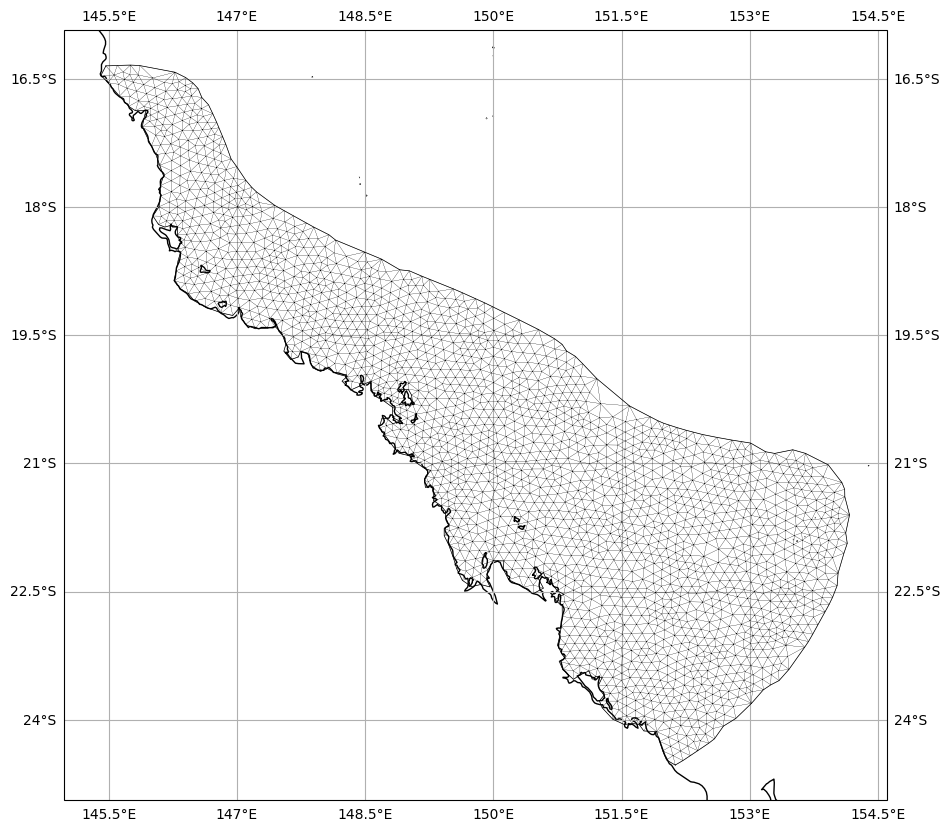

In [5]:
# Visualize the computational grid
# This shows the triangular mesh elements and domain boundaries
grid.plot()

(<Figure size 1200x1000 with 2 Axes>, <GeoAxes: >)

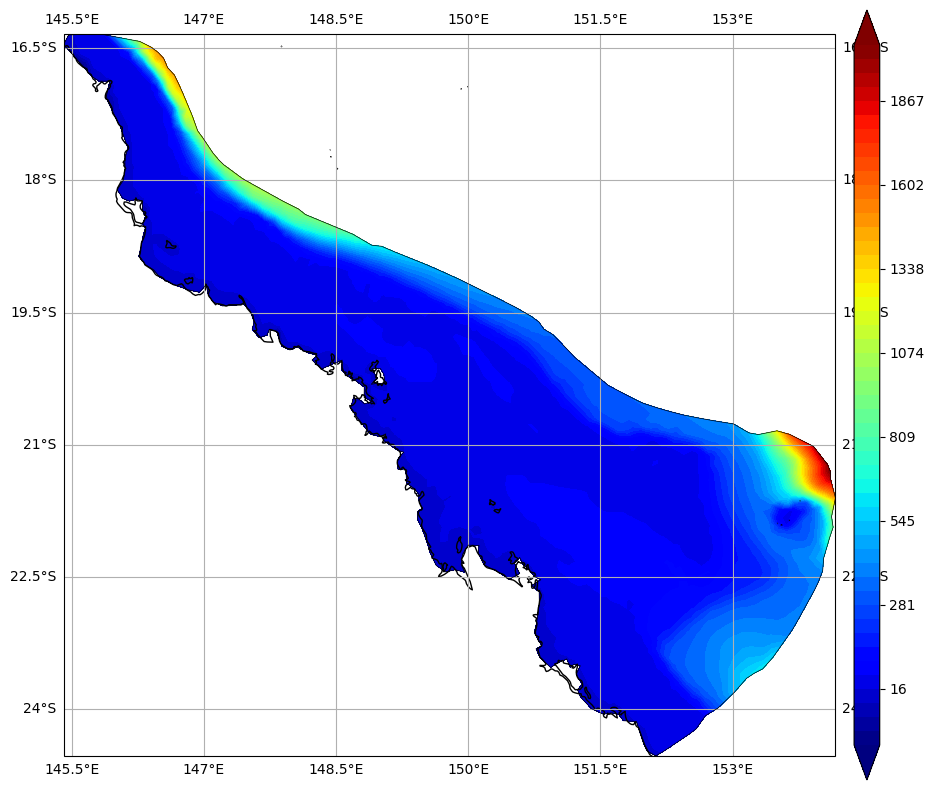

In [6]:
# Visualize the bathymetry (water depth) across the model domain
# Bathymetry is critical for accurate hydrodynamic modeling
# Positive values = water depth, negative values = land elevation
grid.plot_bathymetry()

In [7]:
# Generate grid files in the workspace
# This creates the necessary grid files that SCHISM needs to run:
# - hgrid.gr3: Main grid file with coordinates and bathymetry
# - Additional mesh files as needed

grid.get(workdir)

# Check what new files were created
contents = print_new_contents(workdir, old_contents=contents)

2025-10-06 17:20:04 [INFO] rompy_schism.grid   : Generating albedo.gr3 with constant value 0.15
2025-10-06 17:20:04 [INFO] rompy_schism.grid   : Generating diffmin.gr3 with constant value 1e-06
2025-10-06 17:20:04 [INFO] rompy_schism.grid   : Generating diffmax.gr3 with constant value 1.0
2025-10-06 17:20:05 [INFO] rompy_schism.grid   : Generating watertype.gr3 with constant value 1.0
2025-10-06 17:20:05 [INFO] rompy_schism.grid   : Generating windrot_geo2proj.gr3 with constant value 0.0
2025-10-06 17:20:05 [INFO] rompy_schism.grid   : Generating drag.gr3 with constant value 1.0
2025-10-06 17:20:05 [INFO] rompy_schism.grid   : Linking hgrid.gr3 to schism_demo/hgrid.ll
2025-10-06 17:20:05 [INFO] rompy_schism.grid   : Linking hgrid.gr3 to schism_demo/hgrid_WWM.gr3
2025-10-06 17:20:05 [INFO] rompy_schism.grid   : → Generating vertical grid configuration
2025-10-06 17:20:05 [INFO] rompy_schism.vgrid  : Creating vgrid.in with ivcor=2, nvrt=2, zlevels=-1000000.0, h_c=40.0, theta_b=0.5, theta


Contents of schism_demo:
 - hgrid.gr3 (new)
 - albedo.gr3 (new)
 - diffmin.gr3 (new)
 - diffmax.gr3 (new)
 - watertype.gr3 (new)
 - windrot_geo2proj.gr3 (new)
 - drag.gr3 (new)
 - hgrid.ll (new)
 - hgrid_WWM.gr3 (new)
 - wwmbnd.gr3 (new)
 - vgrid.in (new)
 - tvd.prop (new)


# Forcing Data Configuration

SCHISM requires various types of forcing data to drive the simulation:

## Atmospheric Forcing (Sflux)
- **Wind fields**: Surface wind velocity components (u10, v10)
- **Air pressure**: Mean sea level pressure (optional)
- **Air temperature**: For heat flux calculations (optional)
- **Humidity**: For evaporation calculations (optional)

## Boundary Conditions
- **Tidal forcing**: Harmonic constituents for astronomical tides
- **Ocean forcing**: External water level, temperature, salinity from parent models
- **River inputs**: Freshwater discharge and associated tracers

## Wave Forcing (Optional)
- **Wave spectra**: For wave-current interaction
- **Wave parameters**: Significant wave height, period, direction

In [8]:
# First lists import the main data classes
# Import main forcing data classes for SCHISM
from rompy_schism.data import (
    SCHISMDataSflux,
    SCHISMDataWave,
    SCHISMDataBoundaryConditions,
)

# Import specific forcing components used in data construction
from rompy_schism.data import TidalDataset, SfluxAir, SCHISMDataBoundary

# Import core data source abstractions
# These classes work identically across rompy packages for consistent data handling
from rompy.core.data import DataBlob  # For static data files
from rompy.core.source import SourceFile, SourceIntake  # For various data sources

# Import boundary configuration classes for complex boundary setups
from rompy_schism.data import BoundarySetupWithSource, SCHISMDataBoundary

# Import factory functions for simplified boundary condition configuration
# These provide pre-configured setups for common boundary condition scenarios
from rompy_schism.boundary_conditions import (
    create_tidal_only_boundary_config,  # Pure tidal forcing
    create_hybrid_boundary_config,  # Tidal + external ocean data
    create_river_boundary_config,  # River discharge boundaries
    create_nested_boundary_config,  # Nested model coupling
)

### Atmospheric Forcing (Sflux) Data

SCHISM uses the Sflux format for atmospheric forcing, which organizes meteorological data into structured NetCDF files. The Sflux system:

- **Handles multiple data types**: Wind, pressure, temperature, humidity, radiation
- **Supports flexible grids**: Can interpolate from various input grid formats
- **Manages time series**: Automatically handles temporal interpolation
- **Provides efficient I/O**: Optimized for large-scale simulations

The following example demonstrates setting up wind forcing from ERA5 reanalysis data.

In [9]:
# SCHISMDataSflux??
# SfluxSource??
# Sflux_Inputs??

# Uncomment these lines to explore the Sflux documentation:
# SCHISMDataSflux?  # View SCHISMDataSflux class documentation
# SfluxSource?      # View data source options
# Sflux_Inputs?     # View input parameter details

Text(0.5, 1.0, 'ERA5 Wind Speed 2023-01-01T00:00:00.000000000')

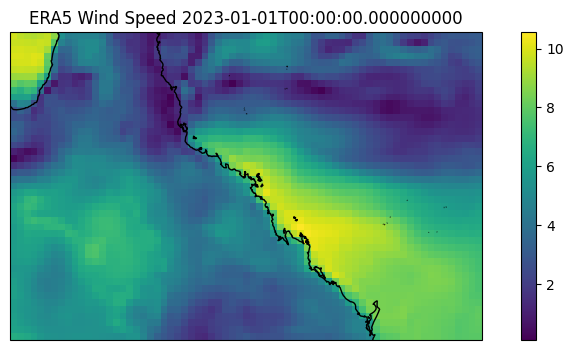

In [10]:
# Load and visualize sample ERA5 atmospheric forcing data
# ERA5 is a global atmospheric reanalysis providing comprehensive meteorological fields

# Initialize variables for visualization
nn = 0  # Time index for plotting (first time step)

# Load data catalog and ERA5 dataset
cat = intake.open_catalog(TEST_DATA / "catalog.yaml")
ds = xr.open_dataset(TEST_DATA / "schism" / "era5.nc")

# Create visualization of wind speed at first time step
plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.PlateCarree())

# Calculate wind speed magnitude from u and v components
wind_speed = np.sqrt(ds.u10[nn] ** 2 + ds.v10[nn] ** 2)

# Plot wind speed with coastlines
wind_speed.plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title(f"ERA5 Wind Speed {ds.time.isel(time=nn).values}")

In [11]:
# Inspect the ERA5 dataset structure
# This shows the dimensions, coordinates, and data variables available
ds

<xarray.Dataset> Size: 3MB
Dimensions:    (time: 73, latitude: 45, longitude: 69)
Coordinates:
  * latitude   (latitude) float32 180B -15.0 -15.25 -15.5 ... -25.5 -25.75 -26.0
  * longitude  (longitude) float32 276B 140.0 140.2 140.5 ... 156.5 156.8 157.0
  * time       (time) datetime64[ns] 584B 2023-01-01 ... 2023-01-04
Data variables:
    msl        (time, latitude, longitude) float32 907kB ...
    u10        (time, latitude, longitude) float32 907kB ...
    v10        (time, latitude, longitude) float32 907kB ...
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    history:                 2024-11-10T00:18 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts
    _coordinates:            {"t":"time","x":"longitude","y":"latitude"}
    _request_size:           907700
    _domain_size:            226665

In [12]:
# Check what variables are available in the ERA5 dataset
print("Available variables in ERA5 dataset:")
print(list(ds.data_vars.keys()))
print("\nDataset info:")
print(ds)

Available variables in ERA5 dataset:
['msl', 'u10', 'v10']

Dataset info:
<xarray.Dataset> Size: 3MB
Dimensions:    (time: 73, latitude: 45, longitude: 69)
Coordinates:
  * latitude   (latitude) float32 180B -15.0 -15.25 -15.5 ... -25.5 -25.75 -26.0
  * longitude  (longitude) float32 276B 140.0 140.2 140.5 ... 156.5 156.8 157.0
  * time       (time) datetime64[ns] 584B 2023-01-01 ... 2023-01-04
Data variables:
    msl        (time, latitude, longitude) float32 907kB ...
    u10        (time, latitude, longitude) float32 907kB ...
    v10        (time, latitude, longitude) float32 907kB ...
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    history:                 2024-11-10T00:18 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts
    _coordinates:            {"t":"time","x":"lon

In [13]:
# Configure atmospheric forcing using ERA5 data
# This demonstrates setting up wind forcing through the Sflux system

from rompy.core.time import TimeRange
from rompy_schism.data import SfluxAir

# Create atmospheric forcing configuration
atmos_forcing = SCHISMDataSflux(
    air_1=SfluxAir(
        id="air_1",  # Identifier for this forcing component
        source=SourceFile(
            uri=TEST_DATA / "schism" / "era5.nc",  # Path to ERA5 data file
        ),
        # Map ERA5 variable names to SCHISM requirements
        uwind_name="u10",  # 10-meter eastward wind component
        vwind_name="v10",  # 10-meter northward wind component
        # Note: prmsl_name (pressure) removed as this ERA5 file lacks 'msl' variable
        # Data processing filters
        filter={
            "sort": {"coords": ["latitude"]},  # Ensure consistent coordinate ordering
        },
        buffer=2,  # Grid buffer for interpolation (grid cells)
    )
)

# Generate Sflux files for the specified time period
# Files are created in workdir/sflux/ directory
atmos_forcing.get(
    destdir=workdir,
    grid=grid,
    time=TimeRange(
        start="2023-01-01", end="2023-01-02", dt=3600
    ),  # 1-day simulation, hourly output
)

2025-10-06 17:20:05 [INFO] rompy_schism.data   : Successfully created SfluxAir instance with source type: <class 'rompy.core.source.SourceFile'>
2025-10-06 17:20:05 [INFO] rompy_schism.data   :   • Variables: air_1
2025-10-06 17:20:05 [INFO] rompy_schism.data   :   • Source: ../tests/data/schism/era5.nc
2025-10-06 17:20:05 [INFO] rompy_schism.data   :   • Output: schism_demo/sflux


{'air_1': PosixPath('schism_demo/sflux/air_1.0001.nc'),
 'nml': PosixPath('schism_demo/sflux/sflux_inputs.txt')}

In [14]:
# Verify that Sflux files were created successfully
# The sflux directory should now contain processed atmospheric forcing files
# These files are in the format required by SCHISM for atmospheric input

contents = print_new_contents(workdir, old_contents=contents)


Contents of schism_demo:
 - hgrid.gr3
 - albedo.gr3
 - diffmin.gr3
 - diffmax.gr3
 - watertype.gr3
 - windrot_geo2proj.gr3
 - drag.gr3
 - hgrid.ll
 - hgrid_WWM.gr3
 - wwmbnd.gr3
 - vgrid.in
 - tvd.prop
 - sflux/

Contents of schism_demo/sflux:
 - air_1.0001.nc (new)
 - sflux_inputs.txt (new)
 - sflux (new)


Text(0.5, 1.0, 'Processed Sflux Wind Speed Data')

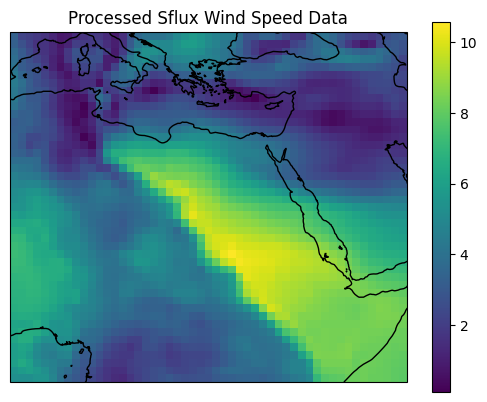

In [15]:
# Visualize the processed Sflux data
# This verifies that the atmospheric forcing was correctly processed and formatted

# Create map projection for visualization
ax = plt.axes(projection=ccrs.PlateCarree())

# Load the processed Sflux file (air_1.0001.nc corresponds to first time file)
ds = xr.open_dataset("schism_demo/sflux/air_1.0001.nc")

# Calculate wind speed magnitude from processed data
wind_speed = np.sqrt(ds.u10.isel(time=nn) ** 2 + ds.v10.isel(time=nn) ** 2)

# Plot the processed wind field
wind_speed.plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title("Processed Sflux Wind Speed Data")

### Boundary Conditions Configuration

SCHISM's new unified boundary conditions system provides a single, comprehensive interface for configuring all types of model boundaries. This represents a significant improvement over the previous separate configuration approach.

#### Boundary Types Supported:
1. **Tidal boundaries**: Harmonic constituents for astronomical tides
2. **Ocean boundaries**: External water level, temperature, salinity from parent models
3. **River boundaries**: Freshwater discharge with associated tracers
4. **Nested boundaries**: Coupling with parent model outputs including relaxation zones

#### Key Advantages:
- **Unified interface**: Single configuration object handles all boundary types
- **Factory functions**: Pre-configured setups for common scenarios
- **Better validation**: Comprehensive error checking and parameter validation
- **Flexible mixing**: Different boundary types can be applied to different segments
- **Seamless integration**: Works directly with the data processing pipeline

The following example demonstrates hybrid boundary conditions combining tidal forcing with external ocean data.

Text(0.5, 1.0, 'HYCOM Sea Surface Elevation - External Ocean Forcing')

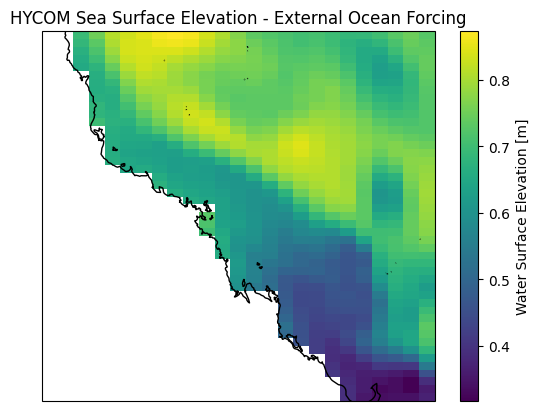

In [16]:
# Load and visualize external ocean forcing data (HYCOM)
# HYCOM provides high-resolution ocean analysis for boundary forcing

ds = xr.open_dataset(TEST_DATA / "schism" / "hycom.nc")

# Create map to visualize sea surface elevation from external ocean model
ax = plt.axes(projection=ccrs.PlateCarree())
ds["surf_el"].isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title("HYCOM Sea Surface Elevation - External Ocean Forcing")

In [17]:
# Configure hybrid boundary conditions (tidal + external ocean data)
# This replaces the old separate SCHISMDataOcean and SCHISMDataTides classes
# with a unified, more flexible approach

boundary_conditions = create_hybrid_boundary_config(
    # Tidal forcing configuration
    # Harmonic constituents for astronomical tidal forcing
    constituents=[
        "M2",
        "S2",
        "N2",
    ],  # Major tidal constituents (M2=principal lunar, S2=principal solar, N2=lunar elliptic)
    # Tidal database configuration
    tidal_database=TEST_DATA / "schism" / "tides",  # Path to tidal harmonic database
    tidal_model="OCEANUM-atlas",  # Specify which tidal atlas to use
    # External ocean data for elevation forcing
    # This provides the non-tidal component of water level variations
    elev_source=SCHISMDataBoundary(
        id="elev2D",  # Identifier for elevation boundary data
        source=SourceFile(
            uri=TEST_DATA / "schism" / "hycom.nc",  # Path to HYCOM ocean model data
        ),
        variables=["surf_el"],  # Variable name for sea surface elevation
        coords={
            "t": "time",  # Time coordinate mapping
            "y": "ylat",  # Latitude coordinate mapping
            "x": "xlon",  # Longitude coordinate mapping
        },
    ),
    # Optional: Additional 3D boundary forcing can be added
    # vel_source=SCHISMDataBoundary(...),  # Temperature forcing
    # temp_source=SCHISMDataBoundary(...),  # Temperature forcing
    # salt_source=SCHISMDataBoundary(...),  # Salinity forcing
)

In [18]:
# Generate boundary condition files for the simulation
# This processes tidal and ocean boundary data and creates the necessary input files

boundary_conditions.get(
    destdir=workdir,
    grid=grid,
    time=TimeRange(start="2023-01-01", end="2023-01-02", dt=3600),
)

# Check what boundary condition files were created
contents = print_new_contents(workdir, old_contents=contents)

2025-10-06 17:20:05 [INFO] rompy_schism.data   : → Processing tidal constituents: m2, s2, n2
2025-10-06 17:20:06 [INFO] rompy_schism.data   : → Generating boundary condition file: bctides.in
2025-10-06 17:20:06 [INFO] rompy_schism.bctides: → Computing tidal factors for 3 constituents
2025-10-06 17:20:06 [INFO] rompy_schism.bctides: Applying nodal phase corrections to earth equilibrium argument
2025-10-06 17:20:06 [INFO] rompy_schism.bctides: Processing tide for boundary 1
2025-10-06 17:20:06 [INFO] rompy_schism.bctides: Number of boundary nodes: 94
2025-10-06 17:20:06 [INFO] rompy_schism.bctides: Number of tidal coefficients: 3
2025-10-06 17:20:06 [INFO] rompy_schism.bctides: Tidal_data shape: (94, 3, 2)
2025-10-06 17:20:06 [INFO] rompy_schism.data   : → Boundary conditions written successfully
2025-10-06 17:20:06 [INFO] rompy_schism.data   : → Processing boundary data: elevation
2025-10-06 17:20:06 [INFO] rompy_schism.data   :   • Source: ../tests/data/schism/hycom.nc
2025-10-06 17:20


Contents of schism_demo:
 - hgrid.gr3
 - albedo.gr3
 - diffmin.gr3
 - diffmax.gr3
 - watertype.gr3
 - windrot_geo2proj.gr3
 - drag.gr3
 - hgrid.ll
 - hgrid_WWM.gr3
 - wwmbnd.gr3
 - vgrid.in
 - tvd.prop
 - sflux/

Contents of schism_demo/sflux:
 - air_1.0001.nc (new)
 - sflux_inputs.txt (new)
 - sflux
 - bctides.in (new)
 - elev2D.th.nc (new)


In [19]:
# Inspect the processed boundary condition data
# The elev2D.th.nc file contains time series of elevation boundary conditions

dsb = xr.open_dataset("schism_demo/elev2D.th.nc")
# Display the first time step to verify proper time handling
dsb.time[0]

<xarray.DataArray 'time' ()> Size: 8B
array('2023-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2023-01-01
Attributes:
    long_name:      Time
    standard_name:  time
    base_date:      [2023    1    1    0    0    0]

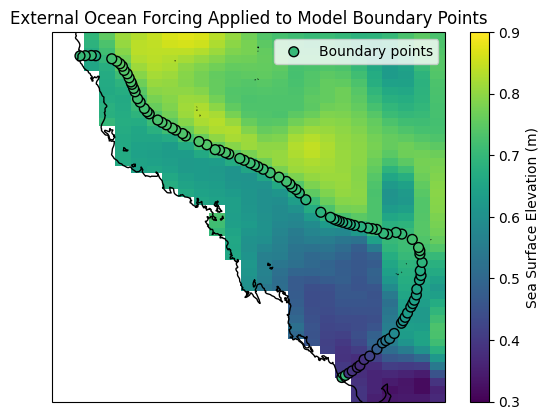

In [20]:
# Visualize boundary condition application
# This shows how external ocean data is interpolated to the model boundary points

# Set color scale limits for consistent visualization
vmin, vmax = 0.3, 0.9
time = dsb.time[0]

# Create map projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the original HYCOM sea surface elevation field
ds["surf_el"].sel(time=time).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    vmin=vmin,
    vmax=vmax,
    cbar_kwargs={"label": "Sea Surface Elevation (m)"},
)
ax.coastlines()

# Extract boundary condition values at the first time step
values = dsb.time_series.isel(time=0)

# Get boundary point coordinates from the grid
x, y = grid.boundary_points()

# Overlay boundary points with their interpolated values
ax.scatter(
    x,
    y,
    transform=ccrs.PlateCarree(),
    c=values,
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
    edgecolor="black",
    s=50,
    label="Boundary points",
)

ax.set_title("External Ocean Forcing Applied to Model Boundary Points")
ax.legend()

### Understanding the New Boundary Conditions System

The new `SCHISMDataBoundaryConditions` class provides a unified interface for all boundary condition types:

1. **Tidal-only**: Pure harmonic tidal forcing using tidal constituents
2. **Hybrid**: Combined harmonic tidal + external ocean data (what we used above)
3. **River**: Constant or time-varying river inputs with optional tidal forcing on other boundaries
4. **Nested**: Coupling with parent model outputs with relaxation parameters

**Key Benefits:**
- Single configuration object for all boundary types
- Factory functions for common configurations
- Better validation and error checking
- Seamless integration with data processing pipeline
- Flexible mixing of different boundary types per segment

### Alternative Boundary Condition Configurations

The unified boundary conditions system supports several configuration patterns. Here are some additional examples:

In [21]:
# Tidal data is now configured through the unified boundary conditions system
# create_tidal_only_boundary_config creates purely tidal boundaries
# create_river_boundary_config creates river boundaries with optional tidal forcing
# create_nested_boundary_config creates nested model boundaries

In [22]:
# Example: Pure tidal boundary configuration (no external ocean data)
tidal_only_boundary = create_tidal_only_boundary_config(
    constituents=["M2", "S2", "N2"],
    tidal_database=TEST_DATA / "schism" / "tides",
    tidal_model="OCEANUM-atlas",
    nodal_corrections=True,
    tidal_potential=True,
    cutoff_depth=50.0,
)

# Example: River boundary configuration
# Note: River temperature and salinity would be handled separately in the full model setup
river_boundary = create_river_boundary_config(
    river_boundary_index=1,  # Index of the river boundary
    river_flow=-100.0,  # Negative for inflow (m³/s)
    other_boundaries="tidal",  # Other boundaries are tidal
    constituents=["M2", "S2"],
    tidal_database=TEST_DATA / "schism" / "tides",
    tidal_model="OCEANUM-atlas",
)

print(f"Tidal-only boundaries: {len(tidal_only_boundary.boundaries)} configured")
print(f"River boundaries: {len(river_boundary.boundaries)} configured")
print(
    f"Hybrid (main) boundary: {boundary_conditions.setup_type} with {len(boundary_conditions.boundaries)} boundaries"
)

Tidal-only boundaries: 0 configured
River boundaries: 1 configured
Hybrid (main) boundary: hybrid with 1 boundaries


**Note on River Boundary Configuration:**

The `create_river_boundary_config` factory function focuses on the core river flow and boundary topology setup. Additional properties like river temperature and salinity would typically be configured through:

1. **Direct boundary setup:** Using `BoundarySetupWithSource` with custom sources for temperature/salinity
2. **Model initialization:** Through hotstart files or initial conditions
3. **Separate forcing files:** Time-varying temperature/salinity data

This design keeps the factory functions simple and focused on their primary purpose while allowing for more complex configurations through the full API.

# Wave boundaries

## Wave Boundary Forcing

SCHISM can be coupled with wave models (like WWM-III) to simulate wave-current interactions.
When WWM is active, the model requires wave boundary conditions as well. In this examples,
we are uisng spectral output from a WW3 model run. The image below shows the full
spectral output points over the wholed or australia. Similarly to the atmpspheric forcing and oceanum boundary
conditions above, we can simply point the a large lazy dataset, and rompy will extract that times and locations
it needs. In the example case blow, you can see all the spectral output points from WW3 in blue, and the
extracted points in orange. In this case, only those points within a specified distance from the boundary (default of 2 degress),
are used, and interpolated schism boundary points.


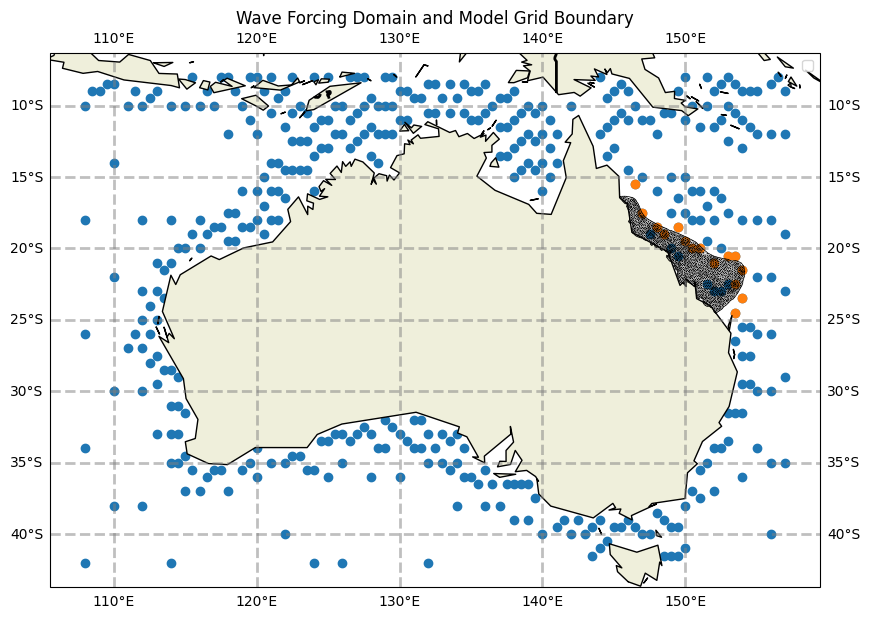

In [23]:
# Configure wave boundary forcing for SCHISM-WWM coupling
# This sets up wave spectra data from an external wave model or observations

wave_forcing = SCHISMDataWave(
    id="wavedata",  # Identifier for wave forcing component
    source=SourceIntake(
        dataset_id="ausspec",  # Wave dataset identifier in the catalog
        catalog_uri=TEST_DATA / "catalog.yaml",  # Path to data catalog
    ),
    coords={
        "x": "lon",  # Longitude coordinate mapping
        "y": "lat",  # Latitude coordinate mapping
    },
)

# Visualize wave forcing domain and boundary application
ax = wave_forcing.plot(model_grid=grid)
wave_forcing.plot_boundary(ax=ax, grid=grid)
ax.set_title("Wave Forcing Domain and Model Grid Boundary")
ax.legend()

# SCHISM Namelist Configuration

SCHISM uses namelist files to configure model parameters, which are organized in a hierarchical structure. The namelist system controls:

## Namelist Structure:
- **Core parameters**: Fundamental simulation settings (time steps, run duration, etc.)
- **Optional parameters**: Advanced configuration options (friction, wind forcing, etc.)
- **Output controls**: Which variables to save and how frequently
- **Physics modules**: Various model components (wave, ice, sediment, etc.)

## Main Namelist Components:
- **`param`**: Main parameter namelist with subsections for core, opt, schout, etc.
- **`core`**: Basic simulation parameters like time step and run length
- **`opt`**: Optional parameters like friction coefficients and forcing options
- **`schout`**: Output control parameters to specify which variables to save

## Additional Physics Modules:
- **`ice`**: Ice model parameters for sea ice simulation
- **`icm`**: Integrated Compartment Model parameters for ecosystem modeling
- **`sediment`**: Sediment transport and morphology parameters
- **`wwminput`**: Wave model input parameters for WWM coupling
- **`cosine`**: CoSiNE ecosystem model parameters
- **`mice`**: Multiple Ice Categories model parameters

The namelist system provides a standardised way to configure the model, ensuring all parameters are properly validated and organised.

# Complete Model Configuration

Now we assemble all forcing components into a complete SCHISM configuration. The main configuration includes:

## Configuration Components:
- **Grid specification**: The computational mesh and bathymetry
- **Forcing data**: Atmospheric, boundary, and wave forcing inputs
- **Namelist parameters**: Model physics, numerics, and output controls
- **Validation**: Ensuring all components are compatible and properly configured

## Namelist Integration:
- **Parameter organization**: All model parameters must be properly placed in the namelist structure
- **Module activation**: Different physical processes are enabled through specific namelist settings
- **Output control**: Variables to save are specified through the schout section of the namelist

In [24]:

from rompy_schism import SCHISMConfig
from rompy_schism.data import SCHISMData
from rompy_schism.namelists import NML
from rompy_schism.namelists.param import Param, Core, Opt, Schout
from rompy_schism.namelists.wwminput import Wwminput, Engs, Proc
from pydantic import ValidationError


# Create comprehensive SCHISM configuration
config = SCHISMConfig(
    # Grid configuration
    grid=grid,
    # Namelist configuration - using correct structure
    nml=NML(
        param=Param(
            # Core parameters can be set here
            core=Core(
                dt=150.0,  # Time step in seconds
                # Set core simulation parameters here if needed
            ),
            schout=Schout(
                # Output control - hydrodynamic variables
                iof_hydro__1=1,  # Water elevation output
                iof_hydro__14=1,  # Wind speed output
                iof_hydro__16=1,  # Surface velocities output
                # Output control - wave variables (WWM coupling)
                iof_wwm__18=1,  # Peak wave direction output
                iof_wwm__1=1,  # Significant wave height output
                iof_wwm__9=1,  # Peak wave period output
            ),
        ),
        wwminput=Wwminput(
            engs=Engs(fricc=0.006),
            proc=Proc(deltc=150.0),
        ),
    ),
    # Complete forcing data configuration
    data=SCHISMData(
        atmos=atmos_forcing,  # Atmospheric forcing (wind)
        boundary_conditions=boundary_conditions,  # Unified boundary conditions
        wave=wave_forcing,  # Wave forcing
    ),
)

print("✓ Complete configuration created successfully!")
print(f"✓ Grid contains {config.grid.pylibs_hgrid.np} nodes")
print(
    f"✓ Forcing components: {len([f for f in [atmos_forcing, boundary_conditions, wave_forcing] if f])} configured"
)

✓ Complete configuration created successfully!
✓ Grid contains 2135 nodes
✓ Forcing components: 3 configured


# Model Execution

With the complete configuration ready, we can now execute the SCHISM simulation. The model run process involves:

## Execution Steps:
1. **Workspace preparation**: Generate all input files in the correct format
2. **Model compilation**: Build SCHISM executable (if using Docker)
3. **Parallel execution**: Run SCHISM using MPI for parallel processing
4. **Output generation**: Write results to NetCDF files

## Performance Considerations:
- **Grid size**: Larger grids require more computational resources
- **Time step**: Smaller time steps increase accuracy but require more computation
- **Output frequency**: More frequent output increases I/O overhead
- **Parallel scaling**: Optimal core count depends on grid size and domain decomposition

Note: Most configuration fields use default values optimized for typical coastal applications.

### Model Run Setup

The `ModelRun` class orchestrates the complete simulation workflow from input preparation through model execution. It handles:

- **Input file generation**: Converts configuration objects to SCHISM input format
- **Workspace organization**: Creates proper directory structure
- **Time management**: Handles simulation period and output intervals
- **Backend integration**: Interfaces with different execution backends (local, Docker, HPC)


In [25]:
# if workdir.exists():
#    rmtree(workdir)

# workdir.mkdir(exist_ok=True)

# Create and configure the model run
# This sets up the complete simulation workflow

from rompy.model import ModelRun

# Configure the model run with all necessary parameters
model_run = ModelRun(
    run_id="test_schism",  # Unique identifier for this simulation run
    # Simulation time period - 12-hour test run with hourly output
    period=TimeRange(
        start=datetime(2023, 1, 1, 0),  # Start: 2023-01-01 00:00:00
        end=datetime(2023, 1, 1, 12),  # End: 2023-01-01 12:00:00
        interval="1h",  # Output every hour
    ),
    output_dir=str(workdir),  # Directory for all simulation files
    config=config,  # Complete SCHISM configuration object
)

# Generate the complete model workspace
# This creates all input files SCHISM needs to run
print("Generating model workspace...")
rundir = model_run()  # Returns path to the run directory
print(f"✓ Model workspace created at: {rundir}")

2025-10-06 17:20:10 [INFO] rompy.model         : ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
2025-10-06 17:20:10 [INFO] rompy.model         : ┃                      MODEL RUN CONFIGURATION                       ┃
2025-10-06 17:20:10 [INFO] rompy.model         : ┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛
2025-10-06 17:20:10 [INFO] rompy.model         :             Run ID : test_schism
2025-10-06 17:20:10 [INFO] rompy.model         :         Model Type : SCHISMConfig
2025-10-06 17:20:10 [INFO] rompy.model         :         Start Time : 2023-01-01T00:00:00
2025-10-06 17:20:10 [INFO] rompy.model         :           End Time : 2023-01-01T12:00:00
2025-10-06 17:20:10 [INFO] rompy.model         :           Duration : 12 hours
2025-10-06 17:20:10 [INFO] rompy.model         :      Time Interval : 1:00:00
2025-10-06 17:20:10 [INFO] rompy.model         :   Output Directory : schism_demo
2025-10-06 17:20:10 [INFO] rompy.model         : ┏━━━━━━

Generating model workspace...


2025-10-06 17:20:10 [INFO] rompy_schism.grid   : Generating windrot_geo2proj.gr3 with constant value 0.0
2025-10-06 17:20:10 [INFO] rompy_schism.grid   : Generating drag.gr3 with constant value 1.0
2025-10-06 17:20:10 [INFO] rompy_schism.grid   : Linking hgrid.gr3 to schism_demo/test_schism/hgrid.ll
2025-10-06 17:20:10 [INFO] rompy_schism.grid   : Linking hgrid.gr3 to schism_demo/test_schism/hgrid_WWM.gr3
2025-10-06 17:20:10 [INFO] rompy_schism.grid   : → Generating vertical grid configuration
2025-10-06 17:20:10 [INFO] rompy_schism.vgrid  : Creating vgrid.in with ivcor=2, nvrt=2, zlevels=-1000000.0, h_c=40.0, theta_b=0.5, theta_f=1.0
2025-10-06 17:20:10 [INFO] rompy_schism.vgrid  : Successfully used create_schism_vgrid to create schism_demo/test_schism/vgrid.in
2025-10-06 17:20:10 [INFO] rompy_schism.grid   : Creating tvd.prop with two-column format for 4030 elements
2025-10-06 17:20:10 [INFO] rompy_schism.grid   : Successfully created tvd.prop with 4030 elements
2025-10-06 17:20:10 [

✓ Model workspace created at: /home/tdurrant/source/rompy/rompy-meta/repos/rompy-schism/notebooks/schism_demo/test_schism


### Summary: Updated Boundary Conditions Workflow

The notebook has been updated to use the new unified boundary conditions system. Here's a summary of the key changes:

**Before (Old System):**
```python
# Separate classes for different boundary types
tidal_forcing = SCHISMDataTides(...)
ocean_forcing = SCHISMDataOcean(...)

# Separate configuration in SCHISMData
data = SCHISMData(
    tides=tidal_forcing,
    ocean=ocean_forcing,
    atmos=atmos_forcing,
    wave=wave_forcing
)
```

**After (New System):**
```python
# Unified boundary conditions with factory functions
boundary_conditions = create_hybrid_boundary_config(
    constituents=["M2", "S2", "N2"],
    tidal_elevations="path/to/tidal_data.nc",
    elev_source=SCHISMDataBoundary(...)
)

# Single boundary_conditions field in SCHISMData
data = SCHISMData(
    boundary_conditions=boundary_conditions,
    atmos=atmos_forcing,
    wave=wave_forcing
)
```

This provides better integration, validation, and flexibility while maintaining all the functionality of the previous system.

# SCHISM Model Execution

The generated workspace now has all required in puts to perform the schism run. This can be done independent of rompy, using, for example,
exiting schism binaries installed on a users system. HOwever, we will  execute the SCHISM model using the rompy backend system.
This system provides flexible execution options including Docker containerization for reproducible, portable simulations. 

## Available Execution Backends:

### Run Backends:
- **Local**: Direct execution on the local machine
- **Docker**: Containerized execution for reproducibility
- **HPC**: High-performance computing cluster integration

### Pipeline Backends:
- **Sequential**: Run components in order
- **Parallel**: Execute independent components simultaneously

### Postprocessors:
- **Output conversion**: Transform results to different formats
- **Visualization**: Generate plots and animations
- **Analysis**: Compute derived quantities and statistics

The Docker backend provides several advantages:
- **Reproducible environment**: Consistent SCHISM build across systems
- **Dependency isolation**: No conflicts with local software
- **Portable execution**: Run anywhere Docker is available
- **Version control**: Specific SCHISM versions with known configurations

See https://rom-py.github.io/rompy/backends.html# for details. 

In [26]:
# Discover available execution backends
# This shows all the backend options available in the current rompy installation

from rompy.model import RUN_BACKENDS, POSTPROCESSORS, PIPELINE_BACKENDS

print("Available Run Backends:")
print("=" * 50)
for name, backend_class in RUN_BACKENDS.items():
    print(f"  • {name}: {backend_class.__name__}")

print(f"\nAvailable Postprocessors:")
print("=" * 50)
for name, processor_class in POSTPROCESSORS.items():
    print(f"  • {name}: {processor_class.__name__}")

print(f"\nAvailable Pipeline Backends:")
print("=" * 50)
for name, pipeline_class in PIPELINE_BACKENDS.items():
    print(f"  • {name}: {pipeline_class.__name__}")

print(
    f"\nTotal backends available: {len(RUN_BACKENDS) + len(POSTPROCESSORS) + len(PIPELINE_BACKENDS)}"
)

Available Run Backends:
  • docker: DockerRunBackend
  • local: LocalRunBackend

Available Postprocessors:
  • noop: NoopPostprocessor

Available Pipeline Backends:
  • local: LocalPipelineBackend

Total backends available: 4


### Docker Backend Configuration

The Docker backend allows us to run SCHISM in a containerized environment using a pre-built Dockerfile. This approach offers several benefits:

#### Advantages of Docker Execution:
- **Consistent environment**: Same SCHISM build regardless of host system
- **Reproducible results**: Identical execution environment across different machines
- **No local dependencies**: SCHISM and all libraries contained in the image
- **Version control**: Specific SCHISM versions with known configurations
- **Resource management**: Control CPU, memory, and other system resources

#### Docker Configuration Parameters:
- **Dockerfile**: Path to SCHISM build instructions
- **Build context**: Directory containing source code and dependencies
- **Resources**: CPU cores, memory limits, execution timeout
- **Volumes**: Mount points for input/output data exchange
- **Environment**: Variables for MPI and execution control

No lets run the model using this dockerfile. We can provide an image, or a Dockerfile that will be build. In this case, we are providing a dockerfile, so this should build the docker (which will take a few minutes the first time its run)

In [27]:
# Configure Docker backend for SCHISM execution
# This Docker builds multiple SCHISM versions - we'll use v5.13.0 with wave coupling

from rompy.backends.config import DockerConfig

# SCHISM version and executable configuration
schism_version = "v5.13.0"
exe_suffix = "_WWM"  # WWM = Wind Wave Model coupling

# MPI execution command for containerized SCHISM
# Running on 8 cores with 4 scribes (output processors)
command = f"cd /tmp/schism && mpirun --oversubscribe --allow-run-as-root -n 8 schism_{schism_version}{exe_suffix} 4"

# Create Docker configuration object
docker_config = DockerConfig(
    # Docker build configuration
    dockerfile=Path("Dockerfile"),  # Dockerfile for SCHISM build
    build_context=Path("../docker/schism"),  # Build context directory
    # Resource limits and timeouts
    timeout=3600,  # 1 hour execution timeout
    cpu=8,  # Number of CPU cores
    memory="4g",  # Memory limit
    # Execution configuration
    executable=f'bash -c "{command}"',  # Command to run inside container
    # Volume mounts for data exchange
    volumes=[f"{rundir}:/tmp/schism:Z"],  # Mount run directory
    # Environment variables for MPI execution
    env_vars={
        "OMPI_ALLOW_RUN_AS_ROOT": "1",  # Allow root user in MPI
        "OMPI_ALLOW_RUN_AS_ROOT_CONFIRM": "1",  # Confirm root user permission
    },
    # Container management
    remove_container=True,  # Clean up after execution
    user="root",  # Run as root user
)

# Execute the model using Docker backend
print("Starting SCHISM execution in Docker container...")
print(f"Command: {command}")
print(f"Resources: {docker_config.cpu} CPUs, {docker_config.memory} memory")
print("This may take several minutes depending on grid size and simulation length...")

# Run the model and capture success status
success = model_run.run(backend=docker_config)
print(f"✓ Docker execution completed successfully: {success}")

2025-10-06 17:20:10 [WARNING] rompy.run.docker    : ! No workspace_dir provided, generating files (this may cause double generation in pipeline)
2025-10-06 17:20:10 [INFO] rompy.model         : ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
2025-10-06 17:20:10 [INFO] rompy.model         : ┃                      MODEL RUN CONFIGURATION                       ┃
2025-10-06 17:20:10 [INFO] rompy.model         : ┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛
2025-10-06 17:20:10 [INFO] rompy.model         :             Run ID : test_schism
2025-10-06 17:20:10 [INFO] rompy.model         :         Model Type : SCHISMConfig
2025-10-06 17:20:10 [INFO] rompy.model         :         Start Time : 2023-01-01T00:00:00
2025-10-06 17:20:10 [INFO] rompy.model         :           End Time : 2023-01-01T12:00:00
2025-10-06 17:20:10 [INFO] rompy.model         :           Duration : 12 hours
2025-10-06 17:20:10 [INFO] rompy.model         :      Time Interval : 1

Starting SCHISM execution in Docker container...
Command: cd /tmp/schism && mpirun --oversubscribe --allow-run-as-root -n 8 schism_v5.13.0_WWM 4
Resources: 8 CPUs, 4g memory
This may take several minutes depending on grid size and simulation length...


2025-10-06 17:20:10 [INFO] rompy_schism.vgrid  : Creating vgrid.in with ivcor=2, nvrt=2, zlevels=-1000000.0, h_c=40.0, theta_b=0.5, theta_f=1.0
2025-10-06 17:20:10 [INFO] rompy_schism.vgrid  : Successfully used create_schism_vgrid to create schism_demo/test_schism/vgrid.in
2025-10-06 17:20:10 [INFO] rompy_schism.grid   : Creating tvd.prop with two-column format for 4030 elements
2025-10-06 17:20:10 [INFO] rompy_schism.grid   : Successfully created tvd.prop with 4030 elements
2025-10-06 17:20:10 [INFO] rompy_schism.config : → Grid files generated successfully
2025-10-06 17:20:10 [INFO] rompy_schism.config : ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
2025-10-06 17:20:10 [INFO] rompy_schism.config : ┃                       PROCESSING INPUT DATA                        ┃
2025-10-06 17:20:10 [INFO] rompy_schism.config : ┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛
2025-10-06 17:20:10 [INFO] rompy_schism.config : → Components: Atmospheric,

✓ Docker execution completed successfully: True


### Model Output Verification

After successful execution, SCHISM generates output files containing simulation results. The key output files include:

#### Primary Output Files:
- **schout_*.nc**: Main output files with hydrodynamic and wave variables
- **param.nml**: Final parameter file with all model settings
- **mirror.out**: Runtime information and performance statistics
- **local_to_global_***: Parallel decomposition mapping files

#### Output Variables (if enabled):
- **Hydrodynamic**: Water elevation, velocities, temperature, salinity
- **Wave fields**: Significant wave height, peak period, wave direction
- **Atmospheric**: Wind speed, air pressure, heat fluxes
- **Bed dynamics**: Bottom stress, sediment transport (if enabled)

In [28]:
# Inspect the model output directory
# This shows all files generated by the SCHISM simulation

print("Model Output Files:")
print("=" * 50)
outputs = print_new_contents(Path(f"{rundir}/outputs"))

Model Output Files:

Contents of /home/tdurrant/source/rompy/rompy-meta/repos/rompy-schism/notebooks/schism_demo/test_schism/outputs:
 - readme.md (new)
 - mirror.out.scribe (new)
 - fatal.error (new)
 - nonfatal_000001 (new)
 - nonfatal_000002 (new)
 - nonfatal_000003 (new)
 - nonfatal_000000 (new)
 - mirror.out (new)
 - total_TR.out (new)
 - total.out (new)
 - JCG.out (new)
 - subcycling.out (new)
 - param.out.nml (new)
 - flux.out (new)
 - global_to_local.prop (new)
 - coriolis.out (new)
 - local_to_global_000000 (new)
 - local_to_global_000002 (new)
 - local_to_global_000003 (new)
 - local_to_global_000001 (new)


## Using configurations files

The advantage of using pydantic to define interfaces is that the entire model can now be descibed as a schema. This means that the entire definition of model run can be described in a single configuration file. 

An instantiated object, can be dumped to a yaml or json file and then used to reinstatiate that same configuration. 

In [29]:
# Export complete model configuration to YAML file
# This creates a comprehensive record of all model settings and data sources

import yaml

print("Exporting complete model configuration...")

# Dump the full model configuration to YAML format
# model_dump() serializes all configuration objects with their current values
with open("full_spec.yaml", "w") as f:
    yaml.dump(model_run.model_dump(), f)

print("✓ Complete model configuration saved to 'full_spec.yaml'")
print(
    "  This file contains all parameters, data sources, and settings used in the simulation"
)
print(
    "  Note: The full dump includes all default values, making it quite comprehensive"
)

Exporting complete model configuration...
✓ Complete model configuration saved to 'full_spec.yaml'
  This file contains all parameters, data sources, and settings used in the simulation
  Note: The full dump includes all default values, making it quite comprehensive


In [30]:
# Display the exported model configuration
# This shows the complete YAML representation of the model setup

print("Complete Model Configuration (model.yaml):")
print("=" * 60)
!cat model.yaml

Complete Model Configuration (model.yaml):
config:
  data:
    atmos:
      air_1:
        _original_inputs:
          buffer: 2
          filter:
            sort:
              coords:
              - latitude
          id: air_1
          uwind_name: u10
          vwind_name: v10
        buffer: 2.0
        coords:
          s: null
          t: time
          x: longitude
          y: latitude
          z: null
        crop_data: true
        data_type: sflux_air
        fail_if_missing: true
        filter:
          crop:
            latitude:
              start: -26.529484917
              stop: -14.3399080571
            longitude:
              start: 143.4089758468
              stop: 156.1664617424
            time:
              start: 2022-12-31 00:00:00
              stop: 2023-01-02 13:00:00
          derived: {}
          rename: {}
          sort:
            coords:
            - latitude
          subset: {}
          timenorm: {}
        id: air_1
        max_windo

### Simplified Configuration Files

The complete model dump shown above includes all parameters with their default values, which makes it comprehensive but verbose. For practical use, the same model configuration can be achieved with much simpler files that specify **only non-default values**.

#### Benefits of Simplified Configurations:
- **Readability**: Focus on the parameters that matter for your specific case
- **Maintainability**: Easier to modify key settings without scrolling through defaults
- **Version control**: Cleaner diffs when configuration changes
- **Documentation**: Serves as concise documentation of model setup choices

#### Example Use Cases:
- **Parameter studies**: Easy to create variants by changing a few key values
- **Reproducible research**: Minimal files that capture the essence of experiments
- **Operational modeling**: Standard configurations for routine forecasting

The `schism_demo.yaml` file below demonstrates this approach with the same configuration using minimal specification.

In [31]:
# Display the simplified demo configuration
# This shows how the same model can be configured with minimal YAML

print("Simplified Model Configuration (schism_demo.yaml):")
print("=" * 50)
print("This compact file achieves the same result as the verbose model.yaml above")
print("by specifying only the non-default parameters.\n")

!cat schism_demo.yaml

Simplified Model Configuration (schism_demo.yaml):
This compact file achieves the same result as the verbose model.yaml above
by specifying only the non-default parameters.

run_id: test_schism
run_id_subdir: true
delete_existing: true
output_dir: schism_demo_config
period:
    start: 2023-01-01 00:00:00
    end: 2023-01-01 12:00:00
config:
    model_type: schism
    grid:
        grid_type: schism
        hgrid:
            id: hgrid
            model_type: data_blob
            source: "../tests/data/schism/hgrid.gr3"
        # vgrid:
        #     source: "../tests/data/schism/vgrid.in"
        drag: 1
    data:
        atmos:
            air_1:
                data_type: sflux_air
                source:
                    model_type: file
                    uri: "../tests/data/schism/era5.nc"
                uwind_name: u10
                vwind_name: v10
                prmsl_name: msl
                filter:
                    sort:
                        coords:
           

In [32]:
# Load and execute model from simplified YAML configuration
# This demonstrates how to reproduce the same simulation using a configuration file

import yaml

print("Loading model from simplified configuration file...")

# Load the demo configuration from YAML
demo_config = yaml.load(open("schism_demo.yaml", "r"), Loader=yaml.FullLoader)

# Create ModelRun object from the loaded configuration
run = ModelRun(**demo_config)

# Clean up any existing run directory to ensure fresh start
if run.output_dir.exists():
    rmtree(run.output_dir)
    print("✓ Cleaned up previous run directory")

# Execute the model run
print("Executing model from configuration file...")
rundir_demo = run()
print(f"✓ Model execution completed. Results in: {rundir_demo}")

2025-10-06 17:20:24 [WARNING] rompy_schism.grid   : ! drag is being set to a constant value, this is not recommended. For best results, please supply friction gr3 files with spatially varying values. Further options are under development.
2025-10-06 17:20:24 [INFO] rompy_schism.data   : Converting air_1 dictionary to SfluxAir object: {'data_type': 'sflux_air', 'source': {'model_type': 'file', 'uri': '../tests/data/schism/era5.nc'}, 'uwind_name': 'u10', 'vwind_name': 'v10', 'prmsl_name': 'msl', 'filter': {'sort': {'coords': ['latitude']}}, 'buffer': 5}
2025-10-06 17:20:24 [INFO] rompy_schism.data   : Converting source dictionary to source object: {'model_type': 'file', 'uri': '../tests/data/schism/era5.nc'}
2025-10-06 17:20:24 [INFO] rompy_schism.data   : Created source object from URI: ../tests/data/schism/era5.nc
2025-10-06 17:20:24 [INFO] rompy_schism.data   : Successfully created SfluxAir instance with source type: <class 'rompy.core.source.SourceFile'>
2025-10-06 17:20:24 [INFO] ro

Loading model from simplified configuration file...
✓ Cleaned up previous run directory
Executing model from configuration file...


2025-10-06 17:20:24 [INFO] rompy_schism.grid   : Generating albedo.gr3 with constant value 0.15
2025-10-06 17:20:24 [INFO] rompy_schism.grid   : Generating diffmin.gr3 with constant value 1e-06
2025-10-06 17:20:24 [INFO] rompy_schism.grid   : Generating diffmax.gr3 with constant value 1.0
2025-10-06 17:20:24 [INFO] rompy_schism.grid   : Generating watertype.gr3 with constant value 1.0
2025-10-06 17:20:24 [INFO] rompy_schism.grid   : Generating windrot_geo2proj.gr3 with constant value 0.0
2025-10-06 17:20:25 [INFO] rompy_schism.grid   : Generating drag.gr3 with constant value 1.0
2025-10-06 17:20:25 [INFO] rompy_schism.grid   : Linking hgrid.gr3 to schism_demo_config/test_schism/hgrid.ll
2025-10-06 17:20:25 [INFO] rompy_schism.grid   : Linking hgrid.gr3 to schism_demo_config/test_schism/hgrid_WWM.gr3
2025-10-06 17:20:25 [INFO] rompy_schism.grid   : → Generating vertical grid configuration
2025-10-06 17:20:25 [INFO] rompy_schism.vgrid  : Creating vgrid.in with ivcor=2, nvrt=2, zlevels=-1

✓ Model execution completed. Results in: /home/tdurrant/source/rompy/rompy-meta/repos/rompy-schism/notebooks/schism_demo_config/test_schism


# Command line interface

Alternatively, these configurations can be simply executed using the cli (https://rom-py.github.io/rompy/cli.html)


In [33]:

!rompy generate schism_demo.yaml -v

print("Executing model via rompy CLI...")
print("Command: rompy schism demo.yaml")
print("=" * 40)

2025-10-06 17:20:27 [INFO] rompy.cli           : Loading config from: schism_demo.yaml
2025-10-06 17:20:27 [INFO] rompy.cli           : Parsed config as YAML
2025-10-06 17:20:27 [WARNING] rompy_schism.grid   : ! drag is being set to a constant value, this is not recommended. For best results, please supply friction gr3 files with spatially varying values. Further options are under development.
2025-10-06 17:20:27 [INFO] rompy_schism.data   : Converting air_1 dictionary to SfluxAir object: {'data_type': 'sflux_air', 'source': {'model_type': 'file', 'uri': '../tests/data/schism/era5.nc'}, 'uwind_name': 'u10', 'vwind_name': 'v10', 'prmsl_name': 'msl', 'filter': {'sort': {'coords': ['latitude']}}, 'buffer': 5}
2025-10-06 17:20:27 [INFO] rompy_schism.data   : Converting source dictionary to source object: {'model_type': 'file', 'uri': '../tests/data/schism/era5.nc'}
2025-10-06 17:20:27 [INFO] rompy_schism.data   : Created source object from URI: ../tests/data/schism/era5.nc
2025-10-06 17:20

Similarly, we can use the cli to run the model using a predifined configuration file. Note that the backend is separted here in a deliberate attemp to keep 
model configuration separte from runtime configuration (https://rom-py.github.io/rompy/developer/architecture/selection_patterns.html#the-two-patterns)

In [34]:
# The equivalent configuration above is given in docker_run_config.yaml
!cat docker_run_config.yaml

type: docker
build_args: {}
build_context: ../docker/schism
cpu: 8
dockerfile: Dockerfile
env_vars:
    OMPI_ALLOW_RUN_AS_ROOT: "1"
    OMPI_ALLOW_RUN_AS_ROOT_CONFIRM: "1"
executable:
    bash -c "cd /tmp/schism && mpirun --oversubscribe --allow-run-as-root
    -n 8 schism_v5.13.0_WWM 4"
memory: 4g
remove_container: true
timeout: 3600
user: root
volumes:
    - ./schism_demo_config/test_schism:/tmp/schism:Z


In [35]:
# Now we can used this configuration to run the model using the rompy cli
!rompy run schism_demo.yaml --backend-config docker_run_config.yaml -v

print("\n✓ CLI execution completed")
print("✓ This demonstrates three equivalent ways to run the same SCHISM simulation:")
print("  1. Programmatic: Create objects and call methods (shown earlier)")
print("  2. Configuration: Load YAML file and create ModelRun object")
print("  3. Command-line: Use 'rompy schism config.yaml' command")

2025-10-06 17:20:31 [INFO] rompy.cli           : Loading config from: schism_demo.yaml
2025-10-06 17:20:31 [INFO] rompy.cli           : Parsed config as YAML
2025-10-06 17:20:31 [WARNING] rompy_schism.grid   : ! drag is being set to a constant value, this is not recommended. For best results, please supply friction gr3 files with spatially varying values. Further options are under development.
2025-10-06 17:20:31 [INFO] rompy_schism.data   : Converting air_1 dictionary to SfluxAir object: {'data_type': 'sflux_air', 'source': {'model_type': 'file', 'uri': '../tests/data/schism/era5.nc'}, 'uwind_name': 'u10', 'vwind_name': 'v10', 'prmsl_name': 'msl', 'filter': {'sort': {'coords': ['latitude']}}, 'buffer': 5}
2025-10-06 17:20:31 [INFO] rompy_schism.data   : Converting source dictionary to source object: {'model_type': 'file', 'uri': '../tests/data/schism/era5.nc'}
2025-10-06 17:20:31 [INFO] rompy_schism.data   : Created source object from URI: ../tests/data/schism/era5.nc
2025-10-06 17:20

## Summary

This notebook has demonstrated a complete SCHISM modeling workflow using the `rompy-schism` package. Here's what we accomplished:

### Key Components Configured:
1. **Computational Grid**: Unstructured triangular mesh with bathymetry
2. **Atmospheric Forcing**: ERA5 wind data via Sflux format
3. **Boundary Conditions**: Hybrid tidal + ocean forcing using the unified system
4. **Wave Forcing**: Spectral wave data for wave-current coupling
5. **Model Execution**: Docker-based containerized simulation

### Workflow Approaches Demonstrated:
- **Procedural**: Step-by-step object creation and configuration
- **Configuration-based**: YAML file-driven model setup
- **Command-line**: Direct execution via `rompy` CLI

### Key Features of the New System:
- **Unified boundary conditions**: Single interface for all boundary types
- **Factory functions**: Simplified configuration for common scenarios
- **Flexible backends**: Docker, local, and HPC execution options
- **Comprehensive validation**: Automatic parameter checking and error reporting

### Next Steps:
- **Parameter studies**: Modify configurations to explore sensitivity
- **Extended simulations**: Run longer time periods with different forcing
- **Advanced analysis**: Use output data for derived quantities and statistics
- **Operational deployment**: Set up automated forecasting workflows

The `rompy-schism` system provides a powerful, flexible framework for coastal ocean modeling with SCHISM, enabling both research applications and operational oceanography.